In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous

class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [2]:
# here we are able to sample rv exactly as in publication
N, beta = 1000,  1/2 # run with n = 1000000
# beta = 1/2 because we want to have a finite mean and for this beta we could check that the code is good
r = frechet.rvs(beta, size=N)
# np.mean(r)
# + histogram of data's

In [3]:
# beta = 1/2 because we want to have a finite mean and for this beta we could check that the code is good

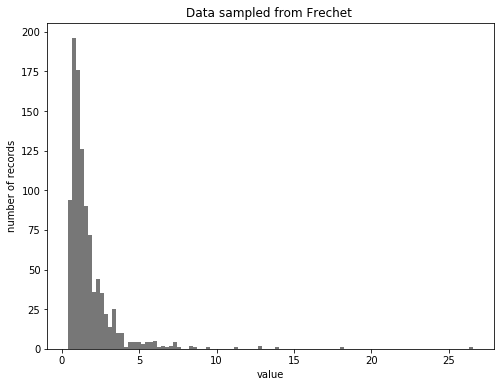

In [4]:
# histogram of data
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Data sampled from Frechet ")

# set x-axis name
ax.set_xlabel("value")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
Nb, bins, patches = ax.hist(r, bins=100, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(Nb, bins, patches):
    if bin_size == 100:
        patch.set_facecolor("#FF000")
        patch.set_label("something")

plt.show()

In [5]:
from prettytable import PrettyTable
m = 3 # how much we round
t = PrettyTable(['pr.distr.', 'mean', 'sd', '92.5%', '95%', '97.5%', '99%', '99.9%'])
t.add_row(['Fréchet',
           "%.3f" % round(np.mean(r),m),
           "%.3f" % round(np.std(r),m),
#            "%.3f" % round(np.percentile(r, 2.5),m), 
#            "%.3f" % round(np.percentile(r, 25),m), 
#            "%.3f" % round(np.percentile(r, 50),m), 
           "%.3f" % round(np.percentile(r, 92.5),m), 
           "%.3f" % round(np.percentile(r, 95),m), 
           "%.3f" % round(np.percentile(r, 97.5),m), 
           "%.3f" % round(np.percentile(r, 99),m),
           "%.3f" % round(np.percentile(r, 99.9),m)])
# t.add_row(['Bob', 19])
print(t)

+-----------+-------+-------+-------+-------+-------+-------+--------+
| pr.distr. |  mean |   sd  | 92.5% |  95%  | 97.5% |  99%  | 99.9%  |
+-----------+-------+-------+-------+-------+-------+-------+--------+
|  Fréchet  | 1.714 | 1.706 | 3.475 | 3.997 | 5.928 | 7.672 | 18.048 |
+-----------+-------+-------+-------+-------+-------+-------+--------+


In [6]:
# we need a function to get a excesses
def k_greatest_values(a,k):
    """returns k greatest elements from the list and k-1 value starting from which we consider values to be extreme"""
    u = np.sort(a, axis=None)[-1-k]
    a = np.sort(a, axis=None)[-1-k+1:]
    a = asarray([a-u for x in a])
    return(a[1].tolist(), u) # u the starting value from which we consider others as excesses

In [7]:
k = 100 # number of excesses
frechet, u = k_greatest_values(r, k)
# frechet # so we recover  k = 100 excesses sampled from Frechet distribution

In [8]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      //return -(1+1/c)*log(1+c*y2);
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  // above distribution is a special case of the distribution in the paper for alpha = beta = 1 / c
  // c = 1/beta
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //real c; 
  real alpha;
  real beta;
}
model {
  // Priors
  // no priors - we assume improper priors on params
  // c ~ uniform(0,1);
  alpha ~ gamma(2,2);
  beta ~ gamma(2,2);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }

}
generated quantities{}
"""

In [9]:
data = dict(N = k,  y = frechet) 
fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_5551b5fb5994a23fc671300ba4c16b27.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   1.57    0.03   0.35   0.99   1.32   1.53   1.83   2.29    115   1.05
beta    1.72    0.06   0.57   0.84   1.28   1.64    2.1   2.88    103   1.05
lp__  -175.4    0.08   1.08 -178.0 -175.9 -175.1 -174.5 -174.2    184    1.0

Samples were drawn using NUTS at Mon May 28 16:19:50 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [10]:
# for the sake of convienience we create a function to make plots of traceplot and histogram (code will be easier to read)
def plot(traceplot, param, distr):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])
    # set x-axis name
    ax[0].set_xlabel("number of iteration")
    ax[0].plot(traceplot)
    ax[0].set_ylabel("value of " + param)
    # set y-axis name
    ax[1].set_xlabel("quantity of records")
    # ax[1].set_ylabel("number of records")

    plt.suptitle('traceplot with histogram of values of alpha parameter in ' + distr + ' fitted to the excesses from Fréchet')
    # titles of subplots, here we don't use it 
    # ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
    # ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")

    # create histogram within output
    Nb, bins, patches = ax[1].hist(traceplot, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins
    return(plt.show())

In [39]:
traceplot_beta_GPD = list(fit.extract().values())[1].tolist() 
traceplot_alpha = list(fit.extract().values())[0].tolist()
traceplot_gamma = np.divide(np.ones(len(traceplot_alpha)), traceplot_alpha)
beta_GPD = np.mean(list(fit.extract().values())[1].tolist())
alpha = np.mean(list(fit.extract().values())[0].tolist())
gamma = 1 / alpha 
print(" alpha = ", alpha, "\n beta = ", beta, "\n gamma = ", gamma)


 alpha =  1.031076782239813 
 beta =  1.7310265825269382 
 gamma =  0.9698598758355272


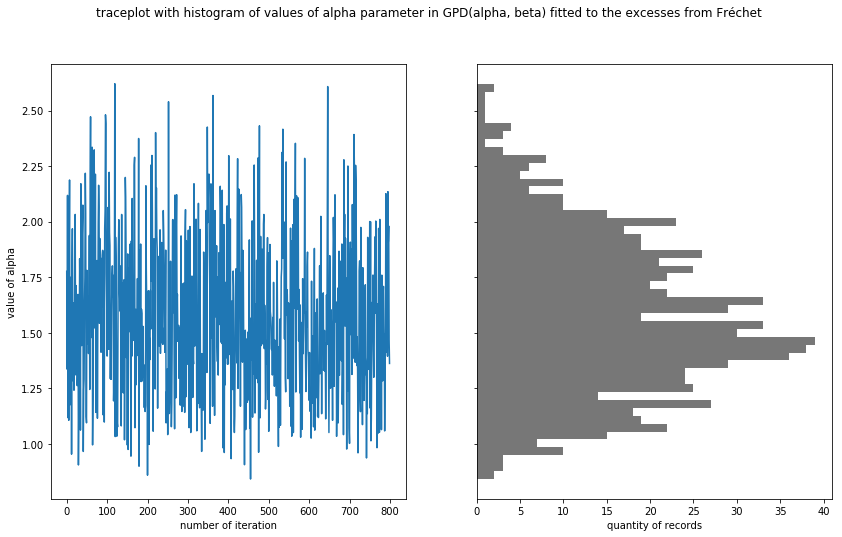

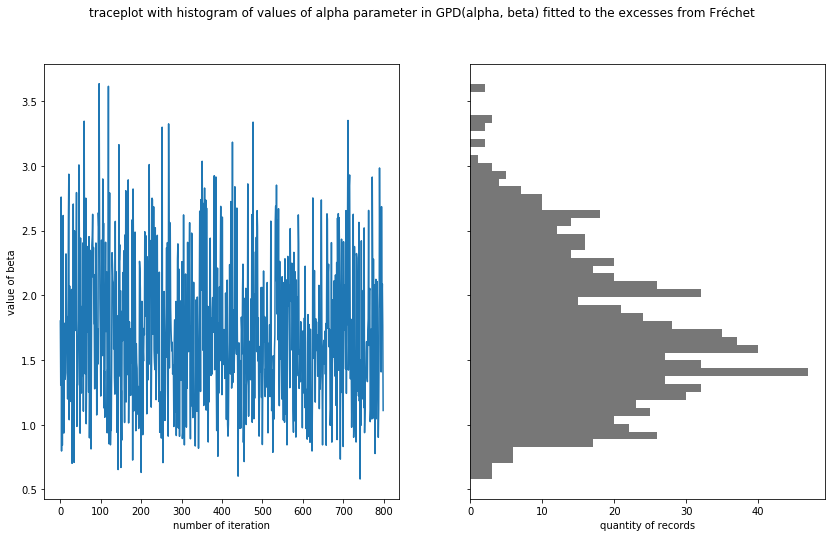

In [12]:
distr = "GPD(alpha, beta)"
plot(traceplot_alpha, "alpha", distr)
plot(traceplot_beta_GPD, "beta", distr)

In [13]:
# check different levels of quantiles to compare them with the original ones in the pretty table above

In [14]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
  
// to recover more general distribution of Fisher parametrized by three parameters we need to multiply the above distribution 
// by: df1**df1/2
// we have alpha1,2 = df1,2/2, beta = df2/df1
}

data { 
  int N;
  real y[N]; // points sampled from fisher in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //parameters of the Fisher
  //real df1;
  //real df2;
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta;
  
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  alpha1 ~ gamma(2,2);
  alpha2 ~ gamma(2,2);
  beta ~ gamma(2,2);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}

generated quantities{}
"""

In [15]:
data = dict(N = k,  y = frechet) 
fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.


Inference for Stan model: anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha1   1.03    0.01   0.19   0.73    0.9   1.01   1.14   1.47    201    1.0
alpha2   1.56    0.02   0.36   0.95    1.3   1.52   1.77   2.42    298    1.0
beta     1.73    0.06   0.77   0.58    1.2   1.62   2.14   3.78    145    1.0
lp__   -177.0    0.09   1.32 -180.4 -177.6 -176.7 -176.0 -175.5    218    1.0

Samples were drawn using NUTS at Mon May 28 16:20:25 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
traceplot_beta = list(fit.extract().values())[2].tolist()
traceplot_alpha1 = list(fit.extract().values())[1].tolist()
traceplot_alpha2 = list(fit.extract().values())[0].tolist()
beta = np.mean(list(fit.extract().values())[2].tolist())
alpha2 = np.mean(list(fit.extract().values())[1].tolist())
alpha1 = np.mean(list(fit.extract().values())[0].tolist())
print(" alpha1 = ", alpha1, "\n alpha2 = ", alpha2, "\n beta = ", beta)
# gamma = 1 / alpha 

 alpha1 =  1.031076782239813 
 alpha2 =  1.5584678897204993 
 beta =  1.7310265825269382


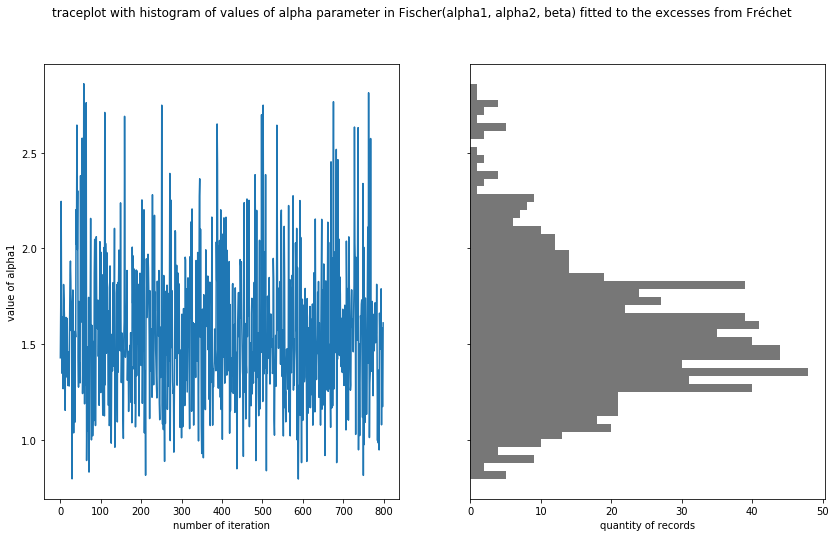

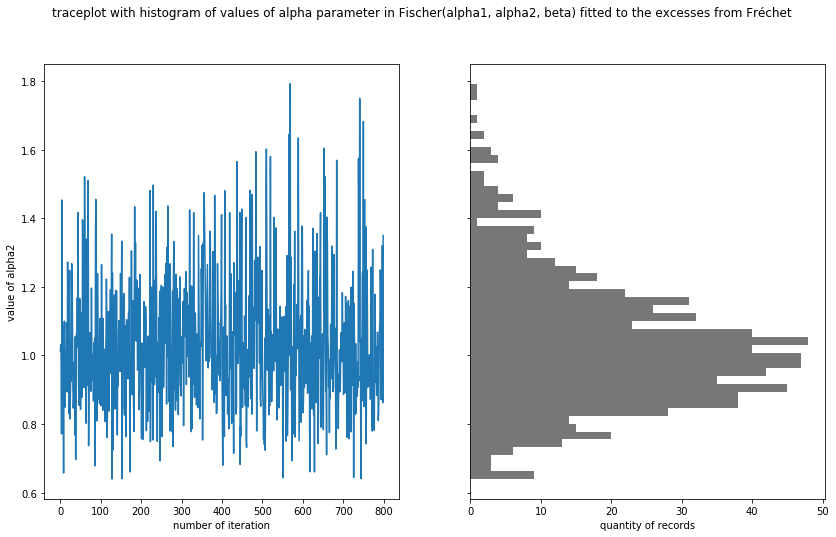

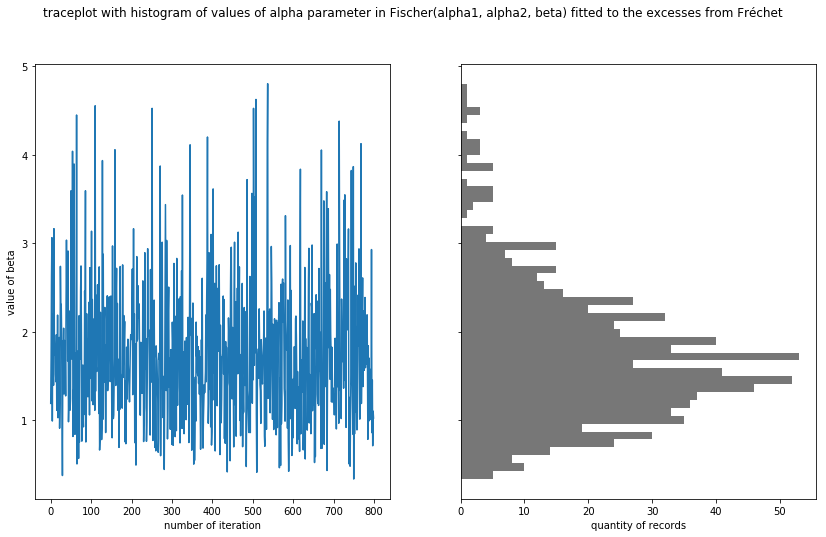

In [17]:
distr = "Fischer(alpha1, alpha2, beta)"
plot(traceplot_alpha1, "alpha1", distr)
plot(traceplot_alpha2, "alpha2", distr)
plot(traceplot_beta, "beta", distr)

In [18]:
# quantiles !

In [19]:
# table to compare with table before (at the beginning)

# def quantile_GPD(N, k, p, beta, gamma, u):
#     quant = u + beta*( ( N * p / k )**( -gamma ) - 1 ) 
#     return( quant) # p = 0.05


In [20]:
print("Below tries to average over multiple sets of excesses, for some reason it doesn't work")

Below tries to average over multiple sets of excesses, for some reason it doesn't work


In [21]:
# def quantile_Fischer(N, k, p, beta, gamma, u):
#     return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05


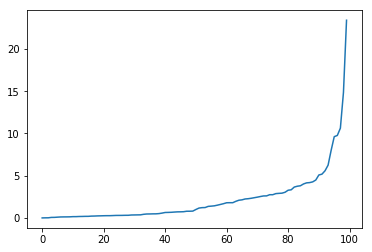

In [22]:
# we want to use build in function to estimate the Fischer quantiles 
from scipy.stats import f
plt.plot(frechet)
plt.show()

In [23]:
# we check the values we will use to obtain quantiles 
values_GPD = [" N = ", N," k = ",  k," beta = ",  beta," gamma = ",  gamma, " u = ", u]

q = [0.925, 0.95, 0.975, 0.99, 0.999]
quant_GPD = np.zeros(len(q)) 
for i in range(len(q)):
    quant_GPD[i] = u + beta_GPD*( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
print(quant_GPD)


[ 3.5229784   4.12877666  5.60490952  8.87881758 33.50821859]


In [24]:
# p = [0.025, 0.25, 0.5, 0.75, 0.975]# to check other values such as p = 0.025, 0.25, 0.5, 0.75, 0.975
quant_Fischer = np.zeros(len(q))
beta0 = alpha2 / alpha1

for i in range(len(q)):
#     q[i] = N * p[i] / k
#     print(q[i])
    quant_Fischer[i] = u + beta0 / beta * f.isf(N / k * (1-q[i]), 2 * alpha1, 2 * alpha2, loc=0, scale=1)
print(quant_Fischer)

[ 3.46205373  3.94977027  5.13588543  7.77525119 27.84408431]


In [25]:
# once again we plot quantiles from the beginning to be able to compare
print(t)
# compare with the theeratical

+-----------+-------+-------+-------+-------+-------+-------+--------+
| pr.distr. |  mean |   sd  | 92.5% |  95%  | 97.5% |  99%  | 99.9%  |
+-----------+-------+-------+-------+-------+-------+-------+--------+
|  Fréchet  | 1.714 | 1.706 | 3.475 | 3.997 | 5.928 | 7.672 | 18.048 |
+-----------+-------+-------+-------+-------+-------+-------+--------+


In [26]:
np.max(r)

26.586229763140405

In [27]:
u

3.178605209208133

In [34]:
np.sort(r)[998]

18.039615800711704

In [28]:
print(" beta0 = ", beta0, "\n beta = ", beta, "\n beta0 / beta = " , beta0/beta, "\n beta / beta0 = ", beta/beta0)

 beta0 =  1.5114954740179796 
 beta =  1.7310265825269382 
 beta0 / beta =  0.8731786613071597 
 beta / beta0 =  1.1452409962733023


In [29]:
np.divide(quant_Fischer, quant_GPD) # here i try to divide the values of quantiles in two arrays, maybe it is some constant?

array([0.98270649, 0.95664421, 0.91631906, 0.87570796, 0.83096283])

In [30]:
np.divide( quant_GPD, quant_Fischer)

array([1.01759784, 1.04532071, 1.09132293, 1.14193321, 1.20342326])

In [31]:
# now if the quantiles are correct we need to average the results

In [ ]:
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# Bayesian way of obtaining the quantiles, we start with quantile estimation for GPD

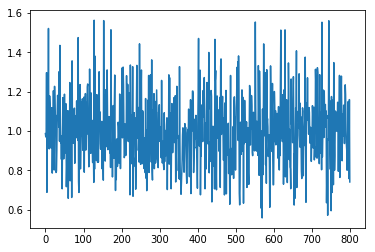

In [40]:
plt.plot(traceplot_gamma)
plt.show()

In [46]:
bayesian_quantile_gpd = np.zeros(len(q))

for j in range(len(q)):
    for i in range(len(traceplot_gamma)):
        bayesian_quantile_gpd[j] = bayesian_quantile_gpd[j] + u + traceplot_beta_GPD[i] * (pow( N * (1 - q[j]) / k, - traceplot_gamma[i] ) - 1)
bayesian_quantile_gpd = bayesian_quantile_gpd / len(traceplot_gamma)
bayesian_quantile_gpd

array([  3.70734557,   4.78408379,   8.14026864,  18.99375587,
       234.51223747])

In [47]:
bayesian_quantile_fisher = np.zeros(len(q))
# u + beta0 / beta * f.isf(N / k * (1-q[i]), 2 * alpha1, 2 * alpha2, loc=0, scale=1)
for j in range(len(q)):
    for i in range(len(traceplot_alpha1)):
        bayesian_quantile_fisher[j] = bayesian_quantile_fisher[j] + u + traceplot_alpha2[i] / traceplot_alpha1[i] / traceplot_beta[i] * f.isf(N / k *(1- q[j]), 2 * traceplot_alpha1[i], 2 * traceplot_alpha2[i], loc=0, scale=1)
bayesian_quantile_fisher = bayesian_quantile_fisher / len(traceplot_alpha1)
bayesian_quantile_fisher

array([ 3.41007916,  3.79380846,  4.86970008,  7.93383905, 53.58501043])

In [ ]:
# check the comparability for chosen quantilies, i.e. for number of excesses k = 5, 10, ..., N / 2 
# plot the value of quantiles, see if it stabilizes

In [55]:
jump_excesses = np.arange(5, N/2, 5).astype(int) # astype function converts the values in the array to integers
# jump_excesses = np.linspace(5, N/2, 5)
jump_excesses

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390,
       395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455,
       460, 465, 470, 475, 480, 485, 490, 495])

In [ ]:
# for each different number of excesses we need to fit both GPD and Fischer distribution
# for this estiamted values get the values of quantiles
frechet, u = k_greatest_values(r, k)
# frechet # so we recover  k = 100 excesses sampled from Frechet distribution

In [32]:
# why are we interested in quantiles ? as I understand because in applications we are given values which are excess values and from
# them we want to infer some truth about prob. distr. generating data, and if quantiles estimated above give us the same quantiles 
# as the true quantiles are them we will dispose some truth about underlying distribution